In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os, sys

# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
code_root = os.path.join(ipynb_dir, '..')
sys.path.append(code_root)  # Needed for import below

from sc2sensor.dataset import StarCraftSensor
from sc2sensor.utils.unit_type_data import NONNEUTRAL_CHANNEL_TO_ID, NONNEUTRAL_ID_TO_NAME
CHANNEL_TO_NAME = [NONNEUTRAL_ID_TO_NAME[NONNEUTRAL_CHANNEL_TO_ID[i]] for i in range(len(NONNEUTRAL_CHANNEL_TO_ID))]

data_root = os.path.join(code_root, 'data') # Data root directory
data_subdir = 'starcraft-sensor-dataset'

In [2]:
# importing * from fast ai 
from fastai.data.all import DataBlock, RandomSplitter
from fastai.vision.all import get_image_files, ImageBlock, MaskBlock

from fastai.vision.all import *
from fastai.callback.all import SaveModelCallback, EarlyStoppingCallback
from fastai.distributed import *
from accelerate import notebook_launcher

In [3]:
def train(name, arch, path_to_images, shared_kwargs, batch_size=256):
    # setting up dataloader
    sc2_segment = DataBlock(
          blocks=(ImageBlock, MaskBlock(codes=CHANNEL_TO_NAME)),
          get_items=get_image_files,
          #get_y=lambda filename: segment_train_path / (os.path.splitext(filename)[0] + '_labels.png'),
          get_y=lambda filename: (os.path.splitext(filename)[0].replace('images','labels') + '_labels.png'),
          splitter=RandomSplitter(seed=0),
          batch_tfms=None)
    dls = sc2_segment.dataloaders(path_to_images, shuffle=True, bs=batch_size)
    
    # initalize model
    learner = unet_learner(arch=arch, dls=dls, **shared_kwargs)
    
    # initalize training hoooks
    callbacks = [EarlyStoppingCallback(patience=1),
                 SaveModelCallback(fname=name, every_epoch=True)]
    
    # distributed learning
    with learner.distrib_ctx(sync_bn=False, in_notebook=True):
        learner.fine_tune(100, cbs=callbacks)
        
    print(f'Finished with {name}!')
    return None

In [5]:
segment_size = 'segment_small'
segment_path = Path(os.path.join(data_root, data_subdir, segment_size))
shared_kwargs = dict(path=Path(code_root), model_dir='models')

experiments = [
# #   ('unet_resnet18', resnet18, 512),
#   ('unet_resnet34', resnet34, 512),
# #   ('unet_resnet50', resnet50, 512),
# #   ('unet_xresnet18', xresnet18_deep, 512),
#   ('unet_xresnet34', xresnet34_deep, 512),
# #   ('unet_xresnet50', xresnet50_deep, 350),
#    ('unet_squeezenet1_0', squeezenet1_0, 350),
#   ('unet_squeezenet1_1', squeezenet1_1, 350),
# #   ('unet_densenet121', densenet121, 128),
  ('unet_densenet169', densenet169, 128),
# #   ('unet_densenet201', densenet201, 128),
]
®
for name, arch, batch_size in experiments:
    print(f'Starting {name}.')
    notebook_launcher(train, (name, arch, segment_path/'train'/'images', shared_kwargs, batch_size),
                      num_processes=2)
    print('\n'*5)

SyntaxError: invalid syntax (1982565204.py, line 15)

#  Old Stuff 
---

In [1]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# from pathlib import Path
# import os, sys

# # Load StarCraft2Sensor stuff
# ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
# model_dir = os.path.join(ipynb_dir, 'models')
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)
# code_root = os.path.join(ipynb_dir, '..')
# sys.path.append(code_root)  # Needed for import below

# from sc2sensor.dataset import StarCraftSensor
# from sc2sensor.utils.unit_type_data import NONNEUTRAL_CHANNEL_TO_ID, NONNEUTRAL_ID_TO_NAME
# CHANNEL_TO_NAME = [NONNEUTRAL_ID_TO_NAME[NONNEUTRAL_CHANNEL_TO_ID[i]] for i in range(len(NONNEUTRAL_CHANNEL_TO_ID))]

# data_root = os.path.join(code_root, 'data') # Data root directory
# data_subdir = 'starcraft-sensor-dataset'

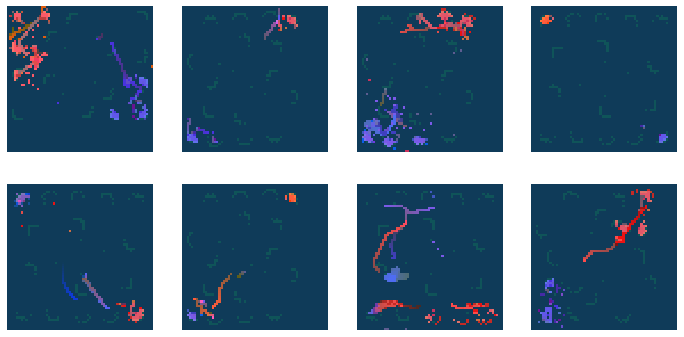

In [2]:
# # Create datablock
# from fastai.data.all import DataBlock, RandomSplitter
# from fastai.vision.all import get_image_files, ImageBlock, MaskBlock

# sc2_segment = DataBlock(
#   blocks=(ImageBlock, MaskBlock(codes=CHANNEL_TO_NAME)),
#   get_items=get_image_files,
#   #get_y=lambda filename: segment_train_path / (os.path.splitext(filename)[0] + '_labels.png'),
#   get_y=lambda filename: (os.path.splitext(filename)[0].replace('images','labels') + '_labels.png'),
#   splitter=RandomSplitter(seed=0),
#   batch_tfms=None)

# segment_size = 'segment'
# segment_path = Path(os.path.join(data_root, data_subdir, segment_size))
# dls = sc2_segment.dataloaders(segment_path/'train'/'images', shuffle=True, bs=64)
# dls.show_batch(max_n=8)

In [ ]:
# learner.validate() # Uses validation set

In [ ]:
# # HACK: Put all instances in both "train" and "valid"
# # From https://forums.fast.ai/t/solved-not-splitting-datablock/84759/3
# def all_splitter(o): return L(int(i) for i in range(len(o))), L(int(i) for i in range(len(o)))

# sc2_segment_test = DataBlock(
#   blocks=(ImageBlock, MaskBlock(codes=CHANNEL_TO_NAME)),
#   get_items=get_image_files,
#   #get_y=lambda filename: segment_train_path / (os.path.splitext(filename)[0] + '_labels.png'),
#   get_y=lambda filename: (os.path.splitext(filename)[0].replace('images','labels') + '_labels.png'),
#   splitter=all_splitter,
#   batch_tfms=None)

# test_dls = sc2_segment_test.dataloaders(segment_path/'test'/'images', shuffle=False, bs=64)
# learner.validate(dl=test_dls.valid) # Uses validation set

In [ ]:
# learner.show_results(max_n=4, figsize=(7,8))

In [ ]:
# from fastai.vision.all import SegmentationInterpretation
# interp = SegmentationInterpretation.from_learner(learner)
# interp.plot_top_losses(k=3, largest=False)
# interp.plot_top_losses(k=3, largest=True)